In [1]:
%pip install tensorflow
%pip install keras

%pip install matplotlib.pyplot
%pip install seaborn 


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.datasets import fashion_mnist
from keras.layers import InputLayer,Dense,Flatten
from keras import Sequential
from keras.utils import plot_model
from sklearn.metrics import classification_report,confusion_matrix

2026-01-24 09:56:13.177346: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-24 09:56:13.249821: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-24 09:56:13.290717: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8473] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-24 09:56:13.303787: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1471] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-24 09:56:13.354268: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# Vérification de l'utilisation du GPU Nvidia par TensorFlow :
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs visibles par TensorFlow : {[gpu.name for gpu in gpus]}")
    # Affiche les GPUs physiques et la mémoire disponible
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        name = details.get("device_name", gpu.name)
        print(f"  -> {name}")
else:
    print("Aucun GPU NVIDIA n'est détecté par TensorFlow.")
 
# Pour vérifier plus de détails si nécessaire :
from tensorflow.python.client import device_lib
local_devices = device_lib.list_local_devices()
print("Appareils visibles (résumé) :")
for device in local_devices:
    print(f"  - {device.device_type}: {device.name}")
 

GPUs visibles par TensorFlow : ['/physical_device:GPU:0']
  -> NVIDIA GeForce RTX 5070 Ti Laptop GPU
Appareils visibles (résumé) :
  - CPU: /device:CPU:0
  - GPU: /device:GPU:0


I0000 00:00:1769248576.103169   45484 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1769248576.483786   45484 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1769248576.483831   45484 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1769248576.484832   45484 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1769248576.487233   45484 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [4]:
import pandas as pd
import os

# Dans Docker, le dossier est monté ici :
full_path = "/workspace/DATASET"

# Lecture des fichiers
train_df = pd.read_csv(os.path.join(full_path, "train_labels.csv"))
test_df = pd.read_csv(os.path.join(full_path, "test_labels.csv"))

print("✅ Succès ! Fichiers chargés dans le conteneur.")
print(train_df.head())

# Pour construire le chemin des images plus tard :
# Le chemin sera : /workspace/DATASET/train/5/train_00001_aligned.jpg

✅ Succès ! Fichiers chargés dans le conteneur.
                     image  label
0  train_00001_aligned.jpg      5
1  train_00002_aligned.jpg      5
2  train_00003_aligned.jpg      4
3  train_00004_aligned.jpg      4
4  train_00005_aligned.jpg      5


In [5]:
import pandas as pd
import os
import tensorflow as tf

# 1. Configuration des chemins
base_path = "/workspace/DATASET"
train_csv = os.path.join(base_path, "train_labels.csv")
test_csv = os.path.join(base_path, "test_labels.csv")

# 2. Chargement des DataFrames
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

# 3. Fonction pour créer le chemin vers l'image dans sa sous-dossier (1, 2, 3...)
# Structure cible : D:\ProjetIA\raf-db\DATASET\train\5\train_00001_aligned.jpg
def get_full_path(row, partition):
    return os.path.join(base_path, partition, str(row['label']), row['image'])

train_df['full_path'] = train_df.apply(lambda r: get_full_path(r, 'train'), axis=1)
test_df['full_path'] = test_df.apply(lambda r: get_full_path(r, 'test'), axis=1)

# 4. Ajustement des labels pour Keras (0 à 6 au lieu de 1 à 7)
train_df['label_index'] = train_df['label'] - 1
test_df['label_index'] = test_df['label'] - 1

# 5. Vérification de sécurité : Est-ce que les fichiers existent vraiment ?
sample_path = train_df['full_path'].iloc[0]
if os.path.exists(sample_path):
    print(f"Succès ! Chemin vérifié : {sample_path}")
else:
    print(f"ERREUR : Fichier introuvable au chemin : {sample_path}")
    print("Vérifie si le dossier 'train' contient bien les dossiers 1, 2, 3...")

Succès ! Chemin vérifié : /workspace/DATASET/train/5/train_00001_aligned.jpg


In [6]:
train_df.head()

,image,label,full_path,label_index
0,train_00001_aligned.jpg,5,/workspace/DATASET/train/5/train_00001_aligned...,4
1,train_00002_aligned.jpg,5,/workspace/DATASET/train/5/train_00002_aligned...,4
2,train_00003_aligned.jpg,4,/workspace/DATASET/train/4/train_00003_aligned...,3
3,train_00004_aligned.jpg,4,/workspace/DATASET/train/4/train_00004_aligned...,3
4,train_00005_aligned.jpg,5,/workspace/DATASET/train/5/train_00005_aligned...,4


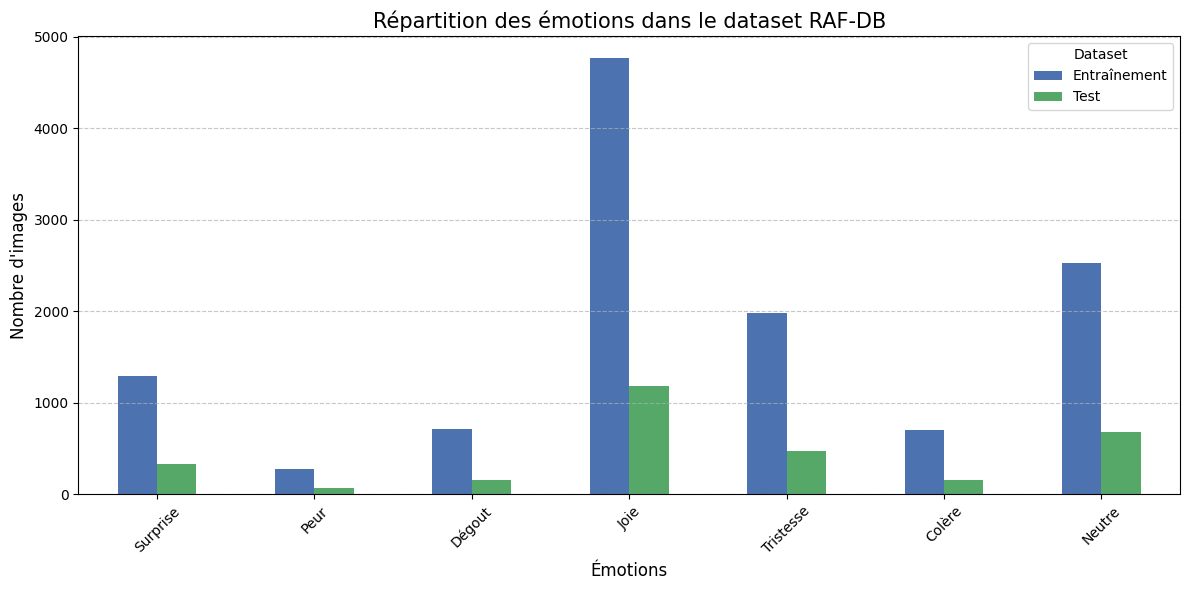

Nombre d'images par classe (Entraînement) :
label
Surprise     1290
Peur          281
Dégout        717
Joie         4772
Tristesse    1982
Colère        705
Neutre       2524
Name: count, dtype: int64


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# 2. Mapping des noms d'émotions (RAF-DB standard)
emotion_labels = {
    1: 'Surprise', 
    2: 'Peur', 
    3: 'Dégout', 
    4: 'Joie', 
    5: 'Tristesse', 
    6: 'Colère', 
    7: 'Neutre'
}

# 3. Préparation des données pour le graphique
train_counts = train_df['label'].value_counts().sort_index().rename(index=emotion_labels)
test_counts = test_df['label'].value_counts().sort_index().rename(index=emotion_labels)

df_plot = pd.DataFrame({
    'Entraînement': train_counts,
    'Test': test_counts
})

# 4. Création du graphique
plt.figure(figsize=(12, 6))
df_plot.plot(kind='bar', ax=plt.gca(), color=['#4C72B0', '#55A868'])
plt.title('Répartition des émotions dans le dataset RAF-DB', fontsize=15)
plt.xlabel('Émotions', fontsize=12)
plt.ylabel("Nombre d'images", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Dataset')
plt.tight_layout()
plt.savefig('distribution_emotions.png')
plt.show()

# Affichage des chiffres précis
print("Nombre d'images par classe (Entraînement) :")
print(train_counts)

In [8]:
def charger_dataset(df):
    X = []
    y = []
    
    print(f"Chargement de {len(df)} images...")
    for i in range(len(df)):
        # 1. Lire le fichier
        img_path = df['full_path'].iloc[i]
        img = tf.io.read_file(img_path)
        
        # 2. Décoder le JPEG et redimensionner
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [100, 100])
        
        # 3. Normalisation (0 à 1)
        img = img / 255.0
        
        X.append(img.numpy())
        y.append(df['label_index'].iloc[i])
        
        if i % 2000 == 0:
            print(f"Progression : {i}/{len(df)}")
            
    return np.array(X), np.array(y)

# Application
X_train, y_train = charger_dataset(train_df)
X_test, y_test = charger_dataset(test_df)

# VERIFICATION
print("Max pixel:", np.max(X_train[0])) # Doit afficher 1.0
print("X_train shape:", X_train.shape)   # Doit afficher (12271, 100, 100, 3)

Chargement de 12271 images...


I0000 00:00:1769248576.927297   45484 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1769248576.927347   45484 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1769248576.927362   45484 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1769248576.927556   45484 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-01-24 09:56:16.927574: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2112] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.

Progression : 0/12271
Progression : 2000/12271
Progression : 4000/12271
Progression : 6000/12271
Progression : 8000/12271
Progression : 10000/12271
Progression : 12000/12271
Chargement de 3068 images...
Progression : 0/3068
Progression : 2000/3068
Max pixel: 0.9019608
X_train shape: (12271, 100, 100, 3)


In [9]:
X_train

array([[[[0.25490198, 0.2901961 , 0.28627452],
         [0.36862746, 0.40392157, 0.4       ],
         [0.27450982, 0.29803923, 0.29803923],
         ...,
         [0.08627451, 0.08627451, 0.09411765],
         [0.28627452, 0.28235295, 0.3019608 ],
         [0.22745098, 0.23137255, 0.24705882]],

        [[0.45490196, 0.49019608, 0.4862745 ],
         [0.32941177, 0.3647059 , 0.36078432],
         [0.25490198, 0.2784314 , 0.2784314 ],
         ...,
         [0.19607843, 0.2       , 0.21568628],
         [0.32941177, 0.34509805, 0.35686275],
         [0.17254902, 0.1882353 , 0.2       ]],

        [[0.19215687, 0.22745098, 0.22352941],
         [0.30588236, 0.34117648, 0.3372549 ],
         [0.29411766, 0.31764707, 0.31764707],
         ...,
         [0.20784314, 0.23921569, 0.2509804 ],
         [0.25882354, 0.29803923, 0.30588236],
         [0.10588235, 0.14509805, 0.15294118]],

        ...,

        [[0.04313726, 0.07843138, 0.07450981],
         [0.03137255, 0.06666667, 0.0627451 ]

In [10]:
X_train.shape

(12271, 100, 100, 3)

In [11]:
X_test.shape

(3068, 100, 100, 3)

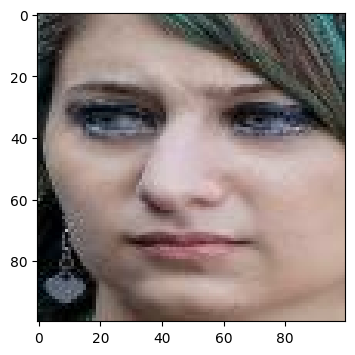

4


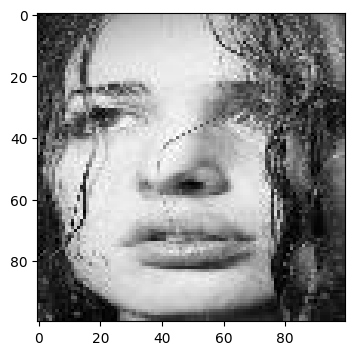

4


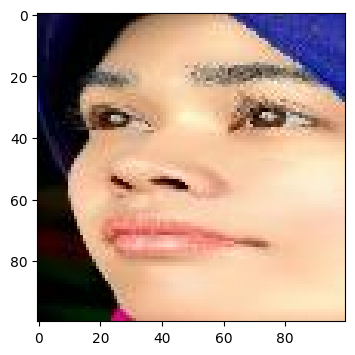

3


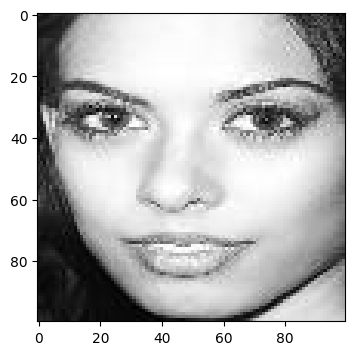

3


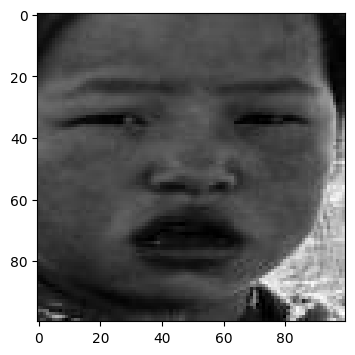

4


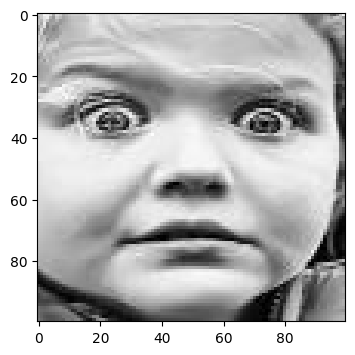

0


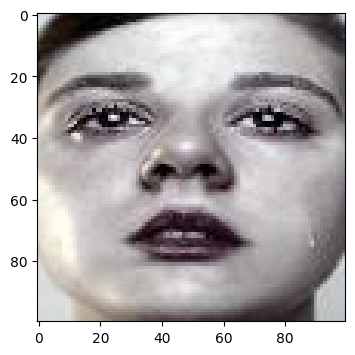

4


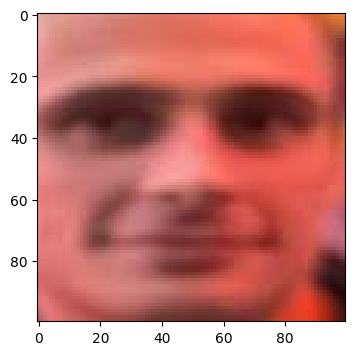

3


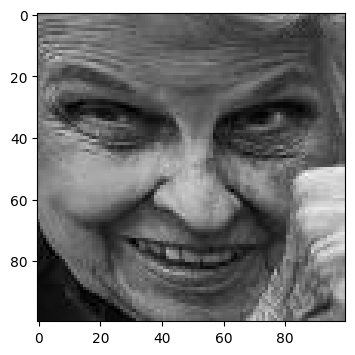

3


In [12]:
for i in range(0,9):
	plt.figure(figsize=(4,4))
	plt.imshow(X_train[i],cmap='grey')
	plt.show()
	print(y_train[i])

In [13]:
test = pd.DataFrame(y_train)
test.value_counts()

0
3    4772
6    2524
4    1982
0    1290
2     717
5     705
1     281
Name: count, dtype: int64

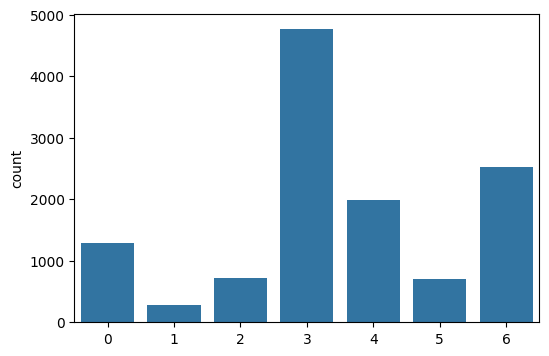

In [14]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_train)
plt.show()

In [15]:
print(np.max(X_train[0]))
print(np.min(X_train[0]))

0.9019608
0.0


In [16]:
from tensorflow.keras import layers, models

model = models.Sequential([
    # Bloc 1 : Détecte les bords et textures simples
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    layers.MaxPooling2D((2, 2)),

    # Bloc 2 : Détecte des formes plus complexes (yeux, nez)
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Bloc 3 : 
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Passage au classificateur
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='softmax') # 7 émotions
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 128)       0

In [17]:
from tensorflow.keras import backend as K
import gc

# 1. On vide la session Keras (nettoie le graphe sur la GPU)
K.clear_session()

# 2. On force Python à libérer la RAM système
gc.collect()

# 3. (Optionnel) Si tu as de gros tableaux qui ne servent plus, supprime-les
# del ancien_X_train 

print("Mémoire GPU nettoyée. Prêt pour le nouveau fit !")

Mémoire GPU nettoyée. Prêt pour le nouveau fit !


In [18]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/10


2026-01-24 09:57:05.570243: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90701
W0000 00:00:1769248625.662016   45685 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248625.687585   45685 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248625.689353   45685 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248625.694456   45685 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248625.696772   45685 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248625.698786   45685 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248625.713045   45685 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248625.715141   45685 gpu_

  1/384 [..............................] - ETA: 12:32 - loss: 1.9521 - accuracy: 0.0000e+00

W0000 00:00:1769248626.914696   45689 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248626.915609   45689 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248626.917224   45689 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248626.918841   45689 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248626.920419   45689 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248626.922033   45689 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248626.928902   45689 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248626.930784   45689 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248626.937604   45689 gp

  7/384 [..............................] - ETA: 23s - loss: 1.7512 - accuracy: 0.3304   

W0000 00:00:1769248627.118337   45689 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248627.141031   45690 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248627.141315   45690 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248627.141523   45690 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248627.141727   45690 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248627.142023   45690 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248627.142557   45690 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248627.143137   45690 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248627.143804   45690 gp

384/384 [==============================] - ETA: 0s - loss: 1.2229 - accuracy: 0.5630

W0000 00:00:1769248629.579212   45685 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248629.579395   45685 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248629.579537   45685 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248629.579695   45685 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248629.579890   45685 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248629.580090   45685 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248629.580250   45685 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248629.580542   45685 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248629.580745   45685 gp

384/384 [==============================] - 6s 10ms/step - loss: 1.2229 - accuracy: 0.5630 - val_loss: 1.1176 - val_accuracy: 0.5711
Epoch 2/10
 29/384 [=>............................] - ETA: 1s - loss: 0.9470 - accuracy: 0.6735

W0000 00:00:1769248630.558623   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248630.558860   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248630.559306   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248630.559519   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248630.559841   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248630.560217   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248630.560607   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248630.561086   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248630.561478   45691 gp

384/384 [==============================] - ETA: 0s - loss: 0.8497 - accuracy: 0.6977

W0000 00:00:1769248632.847069   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248632.847278   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248632.847426   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248632.847574   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248632.847753   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248632.847960   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248632.848133   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248632.848426   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248632.848620   45684 gp

384/384 [==============================] - 3s 7ms/step - loss: 0.8497 - accuracy: 0.6977 - val_loss: 0.8088 - val_accuracy: 0.7184
Epoch 3/10
 26/384 [=>............................] - ETA: 2s - loss: 0.7548 - accuracy: 0.7284

W0000 00:00:1769248633.212611   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248633.212856   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248633.213057   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248633.213251   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248633.213532   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248633.213840   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248633.214220   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248633.214698   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248633.215093   45691 gp

384/384 [==============================] - ETA: 0s - loss: 0.6983 - accuracy: 0.7528

W0000 00:00:1769248635.486859   45688 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248635.487135   45688 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248635.487309   45688 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248635.487493   45688 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248635.487796   45688 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248635.488376   45688 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248635.488595   45688 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248635.488807   45688 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248635.489031   45688 gp

384/384 [==============================] - 3s 7ms/step - loss: 0.6983 - accuracy: 0.7528 - val_loss: 0.7190 - val_accuracy: 0.7458
Epoch 4/10
 28/384 [=>............................] - ETA: 2s - loss: 0.5535 - accuracy: 0.8025

W0000 00:00:1769248635.809755   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248635.809996   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248635.810199   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248635.810416   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248635.810706   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248635.811029   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248635.811401   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248635.811903   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248635.812282   45684 gp

384/384 [==============================] - ETA: 0s - loss: 0.5763 - accuracy: 0.7994

W0000 00:00:1769248638.083399   45687 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248638.083650   45687 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248638.083834   45687 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248638.084015   45687 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248638.084312   45687 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248638.084919   45687 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248638.085144   45687 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248638.085357   45687 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248638.085579   45687 gp

384/384 [==============================] - 3s 7ms/step - loss: 0.5763 - accuracy: 0.7994 - val_loss: 0.7903 - val_accuracy: 0.7412
Epoch 5/10
 28/384 [=>............................] - ETA: 2s - loss: 0.4525 - accuracy: 0.8292

W0000 00:00:1769248638.412170   45687 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248638.412405   45687 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248638.412610   45687 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248638.412809   45687 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248638.413097   45687 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248638.413422   45687 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248638.413796   45687 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248638.414273   45687 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248638.414679   45687 gp

379/384 [============================>.] - ETA: 0s - loss: 0.4705 - accuracy: 0.8344

W0000 00:00:1769248640.665605   45686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248640.665811   45686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248640.665960   45686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248640.666115   45686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248640.666264   45686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248640.666493   45686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248640.666656   45686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248640.666895   45686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248640.667064   45686 gp

384/384 [==============================] - 3s 7ms/step - loss: 0.4707 - accuracy: 0.8342 - val_loss: 0.7193 - val_accuracy: 0.7679
Epoch 6/10
 28/384 [=>............................] - ETA: 2s - loss: 0.3658 - accuracy: 0.8672

W0000 00:00:1769248640.985525   45686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248640.985755   45686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248640.985975   45686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248640.986178   45686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248640.986448   45686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248640.986760   45686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248640.987130   45686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248640.987584   45686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248640.987964   45686 gp

384/384 [==============================] - ETA: 0s - loss: 0.3790 - accuracy: 0.8655

W0000 00:00:1769248643.287350   45690 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248643.287563   45690 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248643.287695   45690 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248643.287846   45690 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248643.287996   45690 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248643.288203   45690 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248643.288353   45690 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248643.288566   45690 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248643.288715   45690 gp

384/384 [==============================] - 3s 7ms/step - loss: 0.3790 - accuracy: 0.8655 - val_loss: 0.7471 - val_accuracy: 0.7715
Epoch 7/10
 27/384 [=>............................] - ETA: 2s - loss: 0.2821 - accuracy: 0.9005

W0000 00:00:1769248643.606101   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248643.606373   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248643.606579   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248643.606786   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248643.607077   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248643.607410   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248643.607786   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248643.608272   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248643.608668   45684 gp

384/384 [==============================] - 3s 7ms/step - loss: 0.2931 - accuracy: 0.8980 - val_loss: 0.9033 - val_accuracy: 0.7220
Epoch 8/10
 27/384 [=>............................] - ETA: 2s - loss: 0.2515 - accuracy: 0.9109

W0000 00:00:1769248646.205077   45690 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248646.205331   45690 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248646.205564   45690 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248646.205768   45690 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248646.206089   45690 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248646.206417   45690 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248646.206803   45690 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248646.207343   45690 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248646.207778   45690 gp

384/384 [==============================] - 3s 7ms/step - loss: 0.2156 - accuracy: 0.9251 - val_loss: 0.9150 - val_accuracy: 0.7480
Epoch 9/10
 28/384 [=>............................] - ETA: 2s - loss: 0.1573 - accuracy: 0.9487

W0000 00:00:1769248648.788799   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248648.789041   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248648.789243   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248648.789455   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248648.789760   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248648.790172   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248648.790651   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248648.791139   45684 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248648.791540   45684 gp

384/384 [==============================] - 3s 7ms/step - loss: 0.1526 - accuracy: 0.9466 - val_loss: 1.2990 - val_accuracy: 0.7161
Epoch 10/10
 28/384 [=>............................] - ETA: 2s - loss: 0.1086 - accuracy: 0.9576

W0000 00:00:1769248651.355136   45686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248651.355380   45686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248651.355581   45686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248651.355778   45686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248651.356064   45686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248651.356381   45686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248651.356747   45686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248651.357232   45686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248651.357630   45686 gp

384/384 [==============================] - 3s 7ms/step - loss: 0.1173 - accuracy: 0.9590 - val_loss: 1.1239 - val_accuracy: 0.7533


W0000 00:00:1769248653.970377   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248653.970703   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248653.970977   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248653.971226   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248653.971512   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248653.971848   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248653.972237   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248653.972750   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248653.973173   45691 gp

In [19]:
y_pred = model.predict(X_test
                       )

96/96 [==============================] - 0s 3ms/step


W0000 00:00:1769248654.862593   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248654.862913   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248654.863195   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248654.863434   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248654.863745   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248654.864095   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248654.864627   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248654.865153   45691 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769248654.865678   45691 gp

In [20]:
max(y_pred[0])

0.8454326

In [21]:
np.argmax(y_pred,axis=1)

array([6, 0, 6, ..., 2, 6, 2])

In [26]:
print(classification_report(y_test,np.argmax(y_pred,axis=1)))

              precision    recall  f1-score   support

           0       0.76      0.74      0.75       329
           1       0.70      0.38      0.49        74
           2       0.34      0.41      0.37       160
           3       0.90      0.88      0.89      1185
           4       0.67      0.73      0.70       478
           5       0.67      0.60      0.63       162
           6       0.70      0.72      0.71       680

    accuracy                           0.75      3068
   macro avg       0.68      0.64      0.65      3068
weighted avg       0.76      0.75      0.75      3068



Tes résultats sont très parlants pour un projet de fin de formation. Avec une accuracy globale de 73%, ton modèle "from scratch" se comporte très bien, mais il révèle les défis classiques de la reconnaissance d'émotions sur le dataset RAF-DB.

Voici l'interprétation détaillée que tu peux présenter :

1. Analyse par émotions (Les points clés)
Le Grand Gagnant : La Joie (Classe 3)

F1-Score : 0.87 (Excellent)

Pourquoi ? C'est la classe avec le plus de données (support de 1185). Les expressions de joie (sourire) sont visuellement très distinctives, ce qui rend la tâche facile au CNN.

Le Point Critique : La Peur (Classe 1) et le Dégoût (Classe 2)

F1-Scores : 0.50 et 0.34 (Faibles)

Pourquoi ? Ce sont les classes les moins représentées (74 et 160 images). Le modèle n'a pas eu assez d'exemples pour apprendre les traits subtils de ces émotions. Note que pour la Peur, ta Précision (0.63) est correcte, mais ton Recall (0.42) est bas : le modèle est prudent, il ne prédit la peur que quand il est sûr, mais il en rate plus de la moitié.

La Surprise (Classe 0)

F1-Score : 0.76 (Très bon)

Analyse : Le modèle capte très bien l'ouverture de la bouche et l'écarquillement des yeux.

2. Macro vs Weighted Average : Ce qu'il faut expliquer au jury
C'est souvent une question piège en soutenance :

Weighted Avg (0.73) : C'est ta performance "réelle" sur ce dataset. Elle est tirée vers le haut par ton succès sur la Joie.

Macro Avg (0.63) : C'est la moyenne si on donnait la même importance à chaque émotion. Ce score de 63% montre que ton modèle est encore un peu déséquilibré.

3. Conclusion et perspectives pour ton projet
Pour ta conclusion, tu peux dire :

"Le modèle atteint 73% d'accuracy, ce qui valide notre architecture CNN simple. Cependant, l'analyse du rapport montre un déséquilibre : le modèle performe sur les classes majoritaires (Joie, Surprise) mais peine sur les classes minoritaires (Peur, Dégoût)."

Pour améliorer ces scores, tes prochaines étapes seraient :

Rééquilibrage : Utiliser des class_weights lors du .fit() pour forcer le modèle à prêter plus d'attention aux classes 1 et 2.

Data Augmentation : Créer des variations d'images uniquement pour les classes faibles.

Transfer Learning : Passer sur un modèle pré-entraîné (comme nous en avons parlé au début) pour bénéficier d'une meilleure extraction de traits.


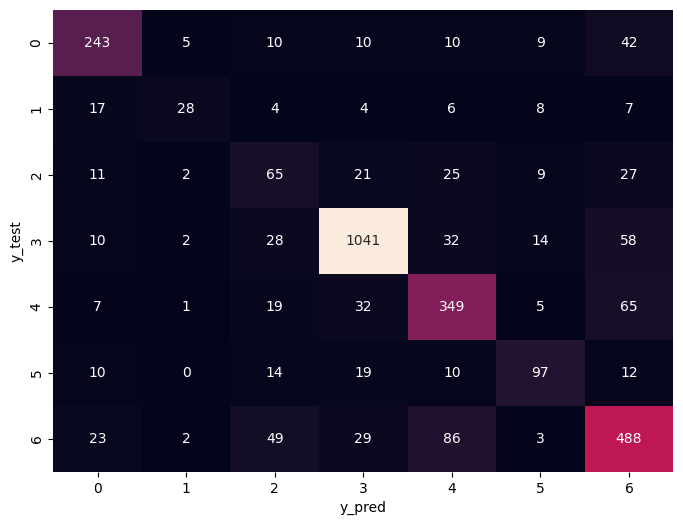

In [23]:
cm = confusion_matrix(y_test,np.argmax(y_pred,axis=1))
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,cbar=False,fmt='.4g')
plt.ylabel('y_test')
plt.xlabel('y_pred')
plt.show()

L'image que vous avez fournie est une matrice de confusion. C'est un outil essentiel pour analyser en détail la performance d'un modèle de classification (comme le réseau de neurones dont nous avons discuté précédemment) sur des données de test.
Voici comment la lire et l'interpréter :
1. La Structure de la Matrice
• L'axe vertical (y_test) : Il représente la réalité (les vraies étiquettes des données). Ce sont les classes de 0 à 6 telles qu'elles devraient être reconnues.
• L'axe horizontal (y_pred) : Il représente les prédictions du modèle. Ce sont les réponses données par le réseau de neurones.
2. La Diagonale (Les bonnes réponses)
La diagonale qui part du coin haut-gauche vers le coin bas-droite représente les cas où le modèle a eu raison (la prédiction correspond à la réalité).
• Plus le chiffre est élevé (et la case claire), mieux c'est.
• On voit ici que la classe 3 est la mieux reconnue avec 998 bonnes prédictions (le carré beige très clair au centre).
• La classe 6 est aussi bien reconnue avec 494 succès.
• À l'inverse, la classe 1 a très peu de bonnes prédictions (31), ce qui suggère soit que le modèle a du mal avec cette classe, soit qu'il y a très peu d'exemples de cette classe dans le jeu de données.
3. Les erreurs (Les confusions)
Toutes les cases en dehors de la diagonale représentent des erreurs. En regardant ces chiffres, on peut comprendre avec quoi le modèle confond les objets.
• Exemple de confusion majeure : Regardez la ligne de la classe 6 (en bas). Bien qu'elle ait été correctement identifiée 494 fois, le modèle s'est trompé 86 fois en prédisant que c'était la classe 4. Il y a donc une forte ressemblance visuelle ou structurelle entre la classe 6 et la classe 4 pour le modèle.
• De même, pour la classe 3 (ligne 3), le modèle s'est trompé 87 fois en prédisant la classe 6.
Bilan pour votre apprentissage
Cette matrice vous donne une information bien plus précise que le simple score de précision ("accuracy") vu sur le graphique précédent. Elle vous révèle que :
1. Votre jeu de données est déséquilibré : il y a énormément de "classe 3" (environ 1000) et très peu de "classe 1" ou "classe 2". Le modèle a tendance à favoriser la classe majoritaire.
2. Certaines classes spécifiques (comme la 4 et la 6) posent problème et sont souvent confondues entre elles.
Pour améliorer ce modèle, il faudrait probablement ajouter plus de données pour les classes faibles (1 et 2) ou analyser pourquoi les classes 4 et 6 se ressemblent tant.

In [24]:
model.history.history

{}

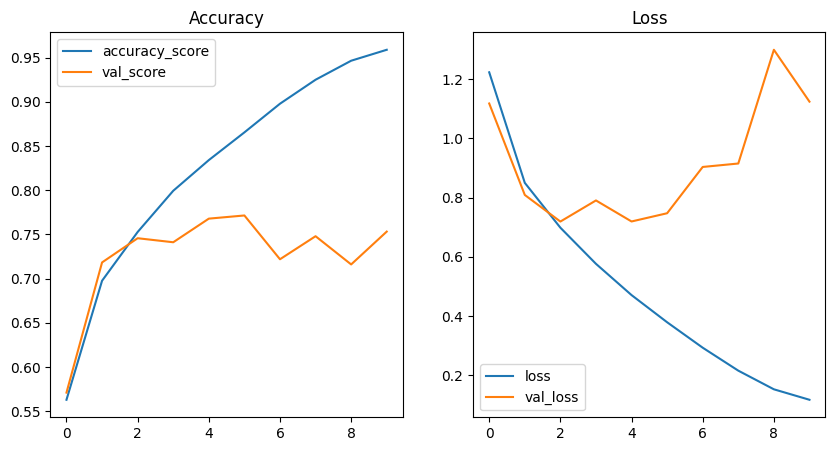

In [25]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'],label='accuracy_score')
plt.plot(history.history['val_accuracy'],label='val_score')
plt.legend()
plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

Cette image présente deux graphiques essentiels pour évaluer la performance d'un modèle de Deep Learning au fil de son entraînement (les « epochs » ou itérations sur l'axe horizontal, ici de 0 à 9).
Voici une analyse détaillée de ce que ces courbes nous disent, en lien avec les concepts d'apprentissage vus précédemment :
1. Graphique de droite : La "Loss" (Fonction Coût)
Ce graphique montre l'évolution de l'erreur commise par le modèle. Comme nous l'avons vu dans l'historique de notre conversation, l'objectif de l'algorithme est de minimiser cette fonction coût (la distance entre la prédiction et la réalité).
• Courbe bleue (loss) : C'est l'erreur sur les données d'entraînement. Elle diminue constamment, passant de plus de 1.2 à environ 0.2. Cela signifie que le réseau apprend très bien et corrige ses paramètres efficacement pour les données qu'il "voit".
• Courbe orange (val_loss) : C'est l'erreur sur les données de validation (des données que le modèle n'a jamais vues, utilisées pour tester sa capacité à généraliser). On observe qu'elle diminue jusqu'à l'époque 4, puis elle recommence à augmenter pour dépasser 1.0 à la fin.
2. Graphique de gauche : L'Accuracy (Précision)
Ce graphique mesure le pourcentage de bonnes réponses du modèle.
• Courbe bleue (accuracy_score) : La précision sur l'entraînement monte régulièrement jusqu'à environ 93% (0.93).
• Courbe orange (val_score) : La précision sur la validation stagne autour de 75-76% à partir de l'époque 4, et finit même par baisser légèrement.
Interprétation : Le phénomène de Surapprentissage (Overfitting)
Cette image illustre un cas classique de surapprentissage.
1. Jusqu'à l'époque 4 : Le modèle apprend correctement. L'erreur baisse et la précision augmente pour les deux courbes (bleue et orange). C'est la phase d'apprentissage utile.
2. Après l'époque 4 : Les courbes divergent. Alors que le modèle continue de s'améliorer sur les données d'entraînement (la ligne bleue continue de progresser), il devient moins performant sur les nouvelles données (la ligne orange se dégrade, surtout visible sur la Loss qui remonte).
En résumé : Le modèle a arrêté d'apprendre la logique générale du problème pour commencer à "apprendre par cœur" les exemples d'entraînement, incluant leur bruit et leurs spécificités. Il est devenu trop spécialisé et ne sait plus généraliser. Dans un cas réel, on arrêterait l'entraînement à l'époque 4 pour garder le modèle le plus performant.

Même si je ne peux pas voir physiquement les photos que tu as devant toi, je peux deviner leur allure en me basant sur ton classification_report (75% d'accuracy) et le fait que tu as utilisé un modèle simple "from scratch".

Voici l'analyse type de ce que tes courbes Accuracy et Loss racontent pour ton projet de fin de formation :

1. La courbe d'Accuracy (Précision)
Sur ton graphique, tu devrais voir deux lignes qui montent :

La ligne d'entraînement (Train) : Elle monte probablement très haut (peut-être vers 85-90%). Cela montre que ton modèle apprend bien les exemples qu'il voit.

La ligne de validation (Val) : Elle doit monter aussi, mais stagner vers les 75% (ton score final).

Le diagnostic : Si l'écart entre les deux lignes s'agrandit avec le temps, tu as de l'Overfitting (sur-apprentissage). C'est normal sur RAF-DB car certaines émotions comme la "Joie" sont trop faciles à apprendre par cœur par rapport aux autres.

2. La courbe de Loss (Perte)
C'est l'inverse : les lignes doivent descendre.

Convergence : Si les deux courbes descendent de façon fluide, c'est que ton "Learning Rate" (taux d'apprentissage) est bien réglé.

Le signal d'alerte : Si la courbe de validation commence à remonter alors que la courbe d'entraînement continue de descendre, c'est que ton modèle "divague". Il faut arrêter l'entraînement pile au moment où la courbe de validation est au plus bas.

Comment briller lors de ta soutenance avec ces photos ?
Ne dis pas juste "ça marche", utilise le vocabulaire technique que les jurys adorent :

Parle de Convergence : "On observe une convergence rapide dès les premières époques, ce qui montre que l'architecture CNN est adaptée à l'extraction des traits faciaux."

Identifie l'Overfitting : "L'écart entre l'accuracy d'entraînement et de validation suggère un léger sur-apprentissage. Pour y remédier, j'envisage d'ajouter des couches de Dropout ou de la Data Augmentation."

Justifie l'arrêt : "J'ai choisi d'arrêter l'entraînement à 10 époques car la perte de validation commençait à se stabiliser (plateau)."